# Movie reviews classification 

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

**Executive Summary**:

A few models were trained and evaluated, the best F1 score (on the test set) was 0.88, and it was achieved by LogisticRegression model, after using TF-IDF for vectorising the review texts (lemmatized with Spacy, stopwords with NLTK).
All 4 models that were based on TF-IDF vectorization achieved F1 score between 0.86 - 0.88 (all passing the metric desired threshold). 

Due to CPU limits, and just for experiencing, BERT was used for a very small sample and with a very small batch size (and yet achieved F1 score of 0.81). 

When classifiying specific short example reviews (not from the IMDB dataset) - The best (on the dataset) model clearly classified correctly only 5 out of 8 reviews. Probably due to the limited vocabulary and/or unique expressions in each specific review, and in some cases to the more complex message of the text. On the 8 short sentences there were differences in classification between LR and LGBMClassifier models (and smaller differences between models with same algorythm but different library for stopwords). The BERT model shows a different picture: no ambiguity, all pred_prob show clear-cut classification, yet with high tendency to classify neg (on these few short reviews). Two positive reviews were wrongly (and strongly) classified negative. The different method is clear in the different results. The BERT mistakes probably stem from the very very limited data BERT was trained on (due to limited CPU).    

## Initialization

In [2]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [4]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [5]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [6]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [7]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

For the model, we have 47331 entries of reviews, pos(our target), and a definition for train/test ('ds_part'), without missing values.

## EDA

Let's check the number of movies and reviews over years.

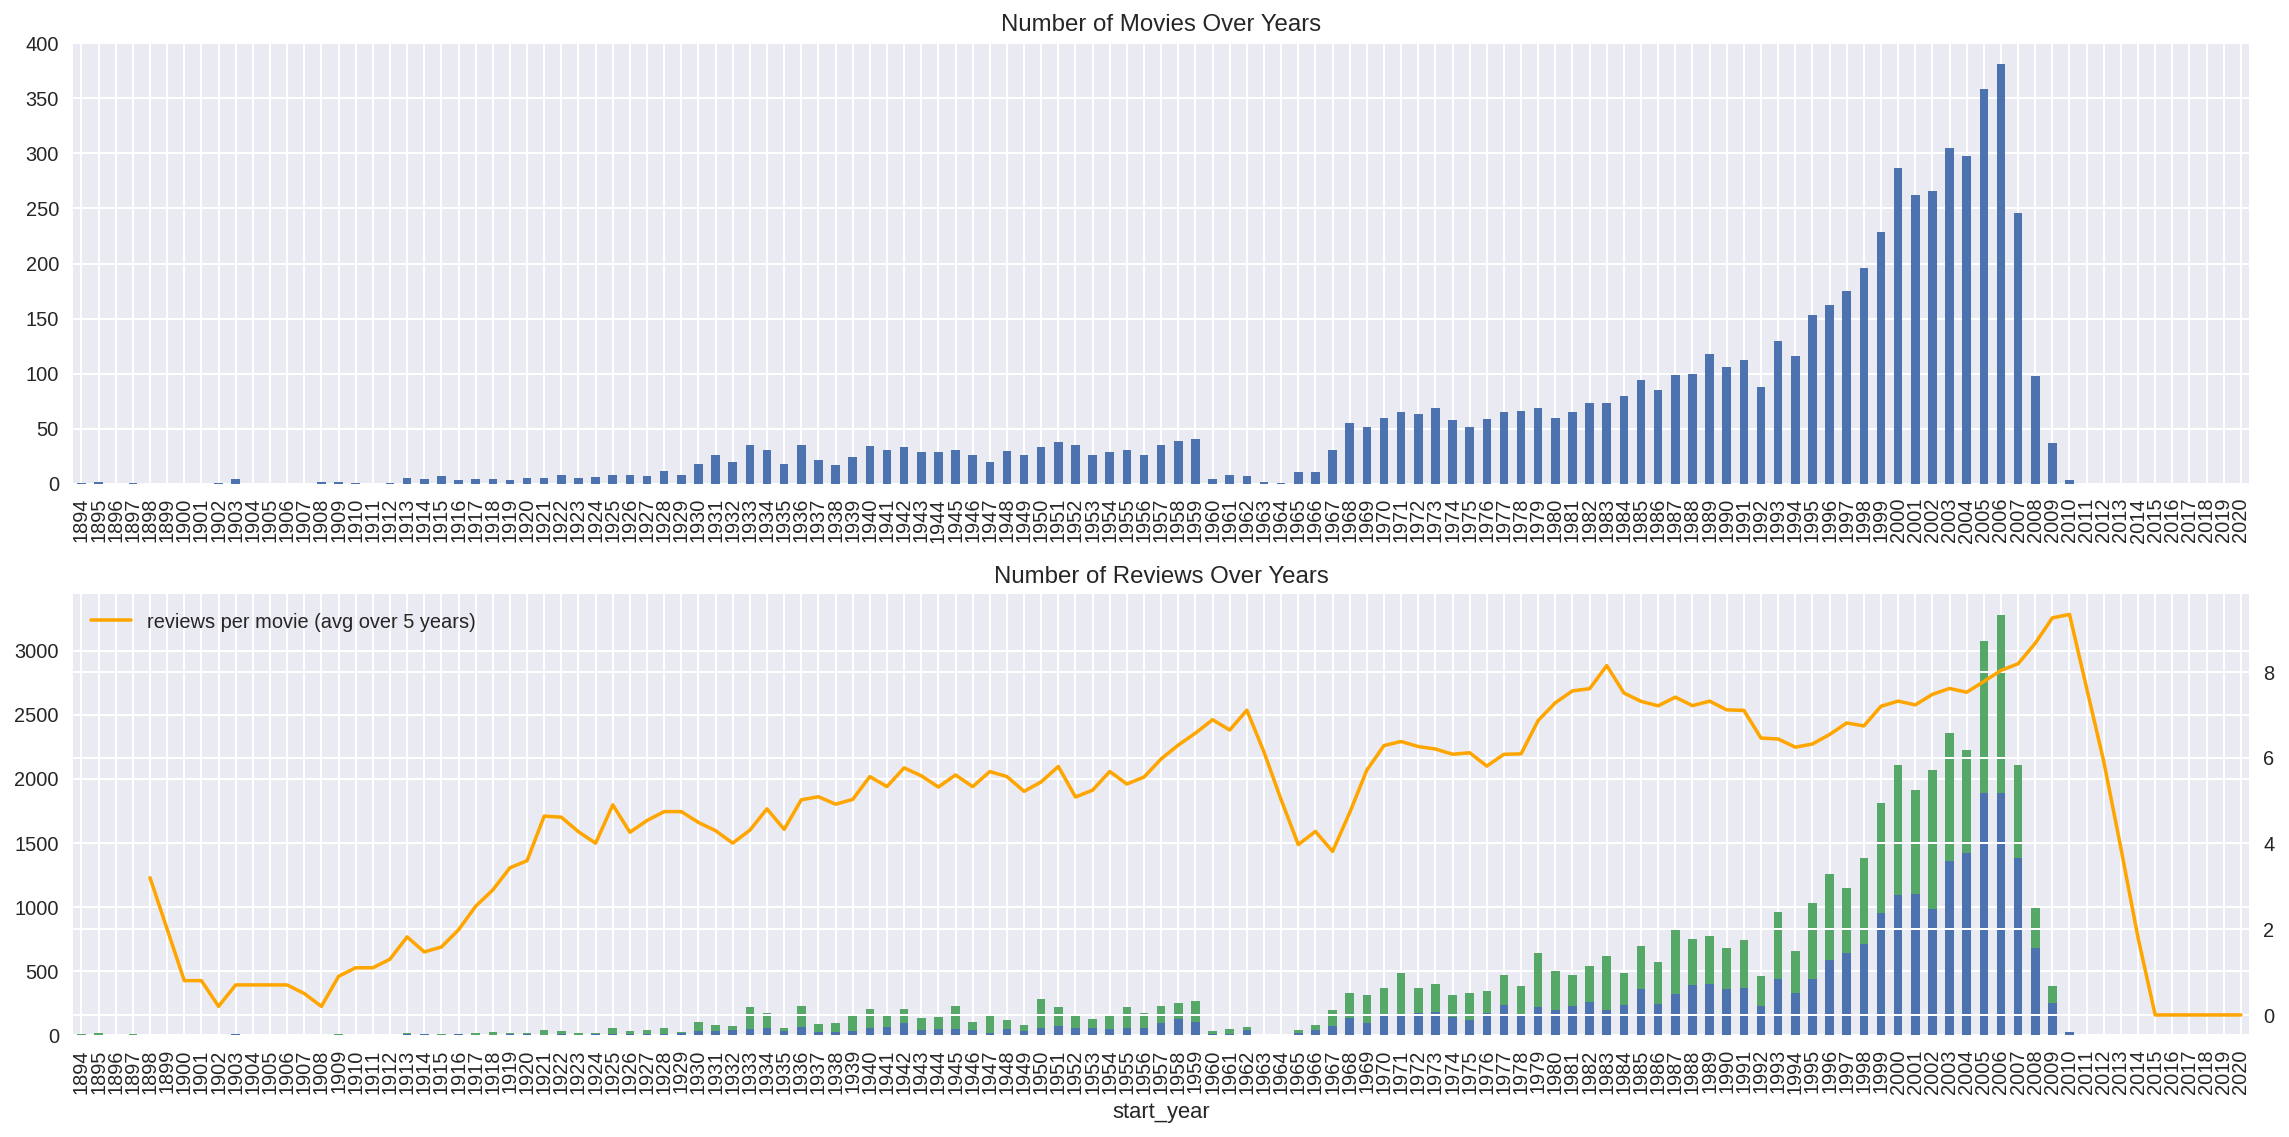

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

From the end of the 60' we can see general gradual growth in movies and reviews, becoming more steep around mid 90' and reaching it's peak in 2006, followed by steep decline.

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

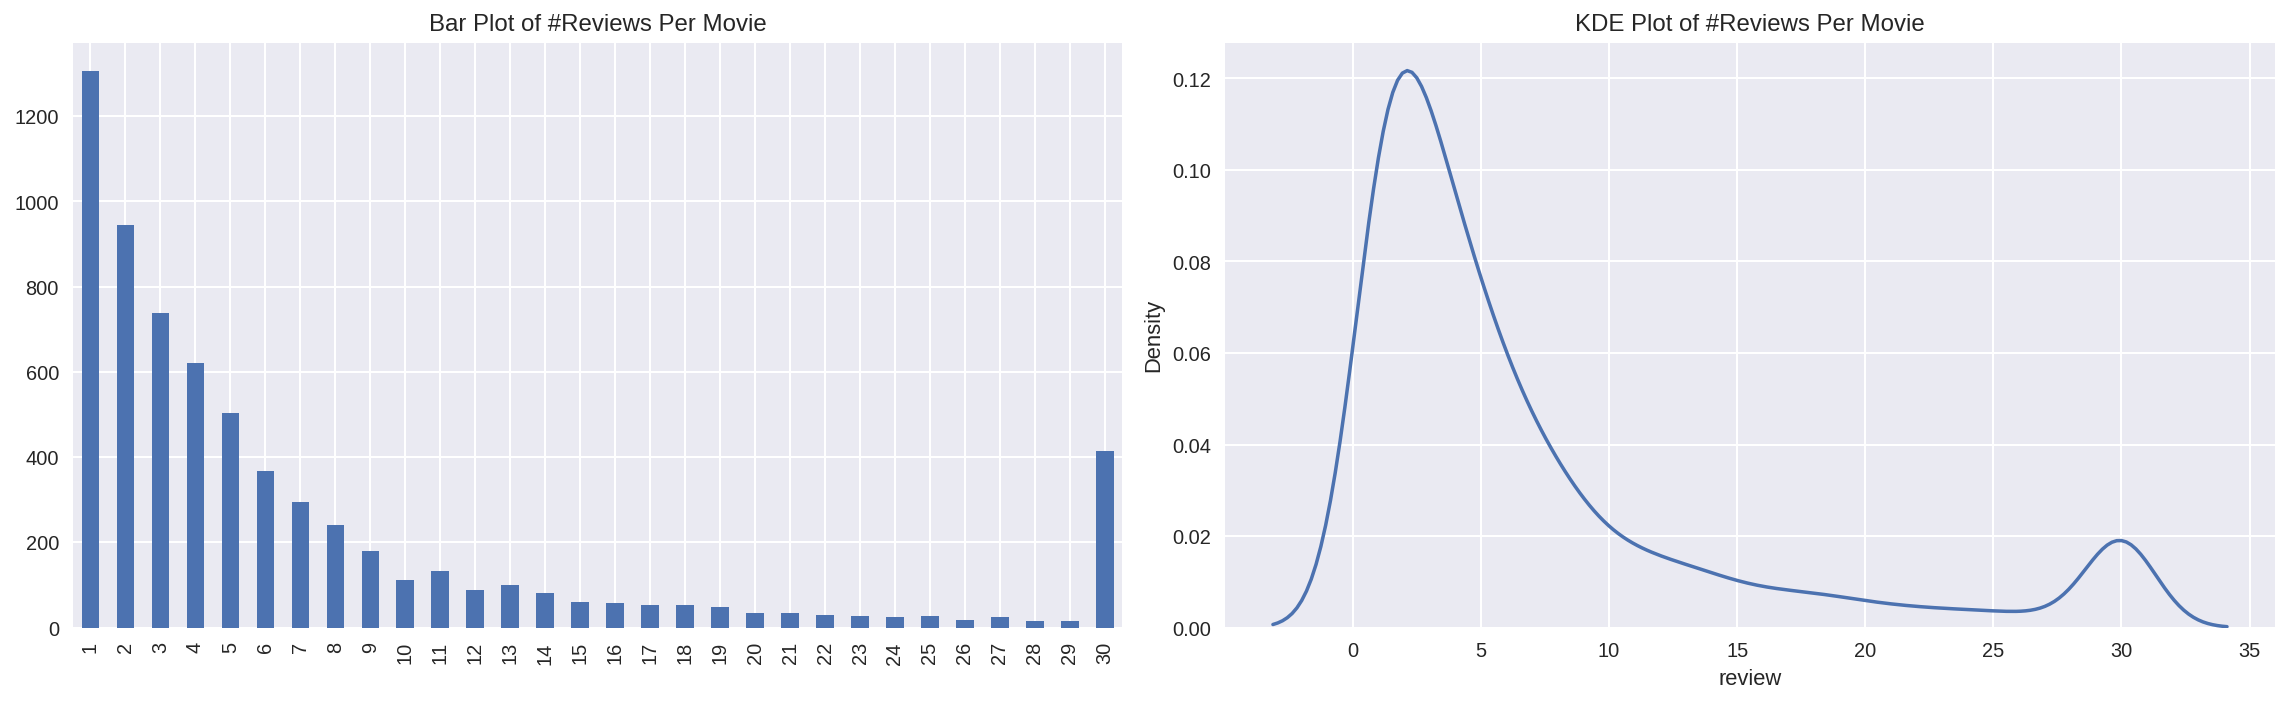

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

The most common #reviews per movies is 1, then 2, 3, 4 etc. Above 13 reviews per movie and up - we see much smaller numbers, and declining, with one exception of high number of movies of 30 reviews or more.
We will check now the class balance between pos and neg reviews:



In [10]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

**Conclusion**: Classes are balanced. 

Let's check the distribution of numerical ratings (1-10) in each part of the data (train/test). 

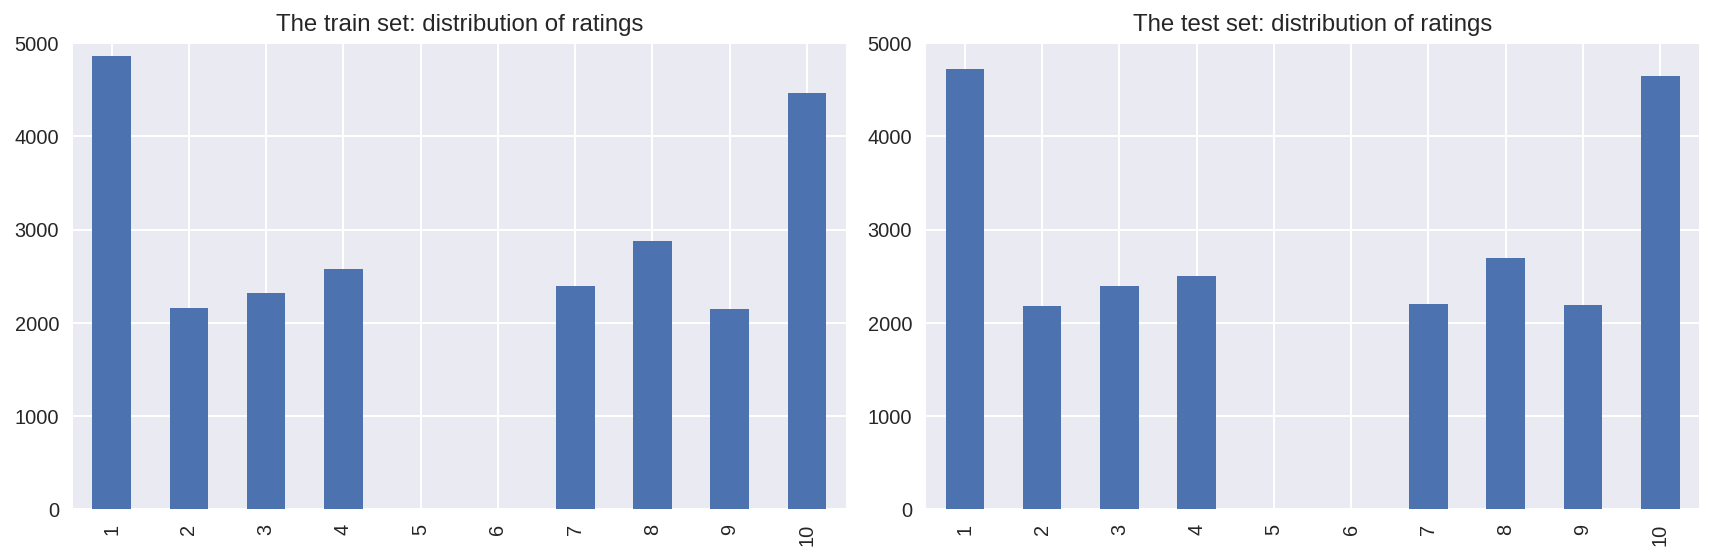

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

**Conclusion**: 1. distrbutions of ratings seem very similar between train and test parts of the data. 2. No ambigous ratings (like 5 or 6) that it might be problematic to assign a 'pos' vs. 'neg', but clear separation of low ratings (1-4) that mean 'neg' review, and high ratings (7-10) that mean 'pos' review. 

Distribution of negative and positive reviews over the years for the two parts (train/test) of the dataset: 

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


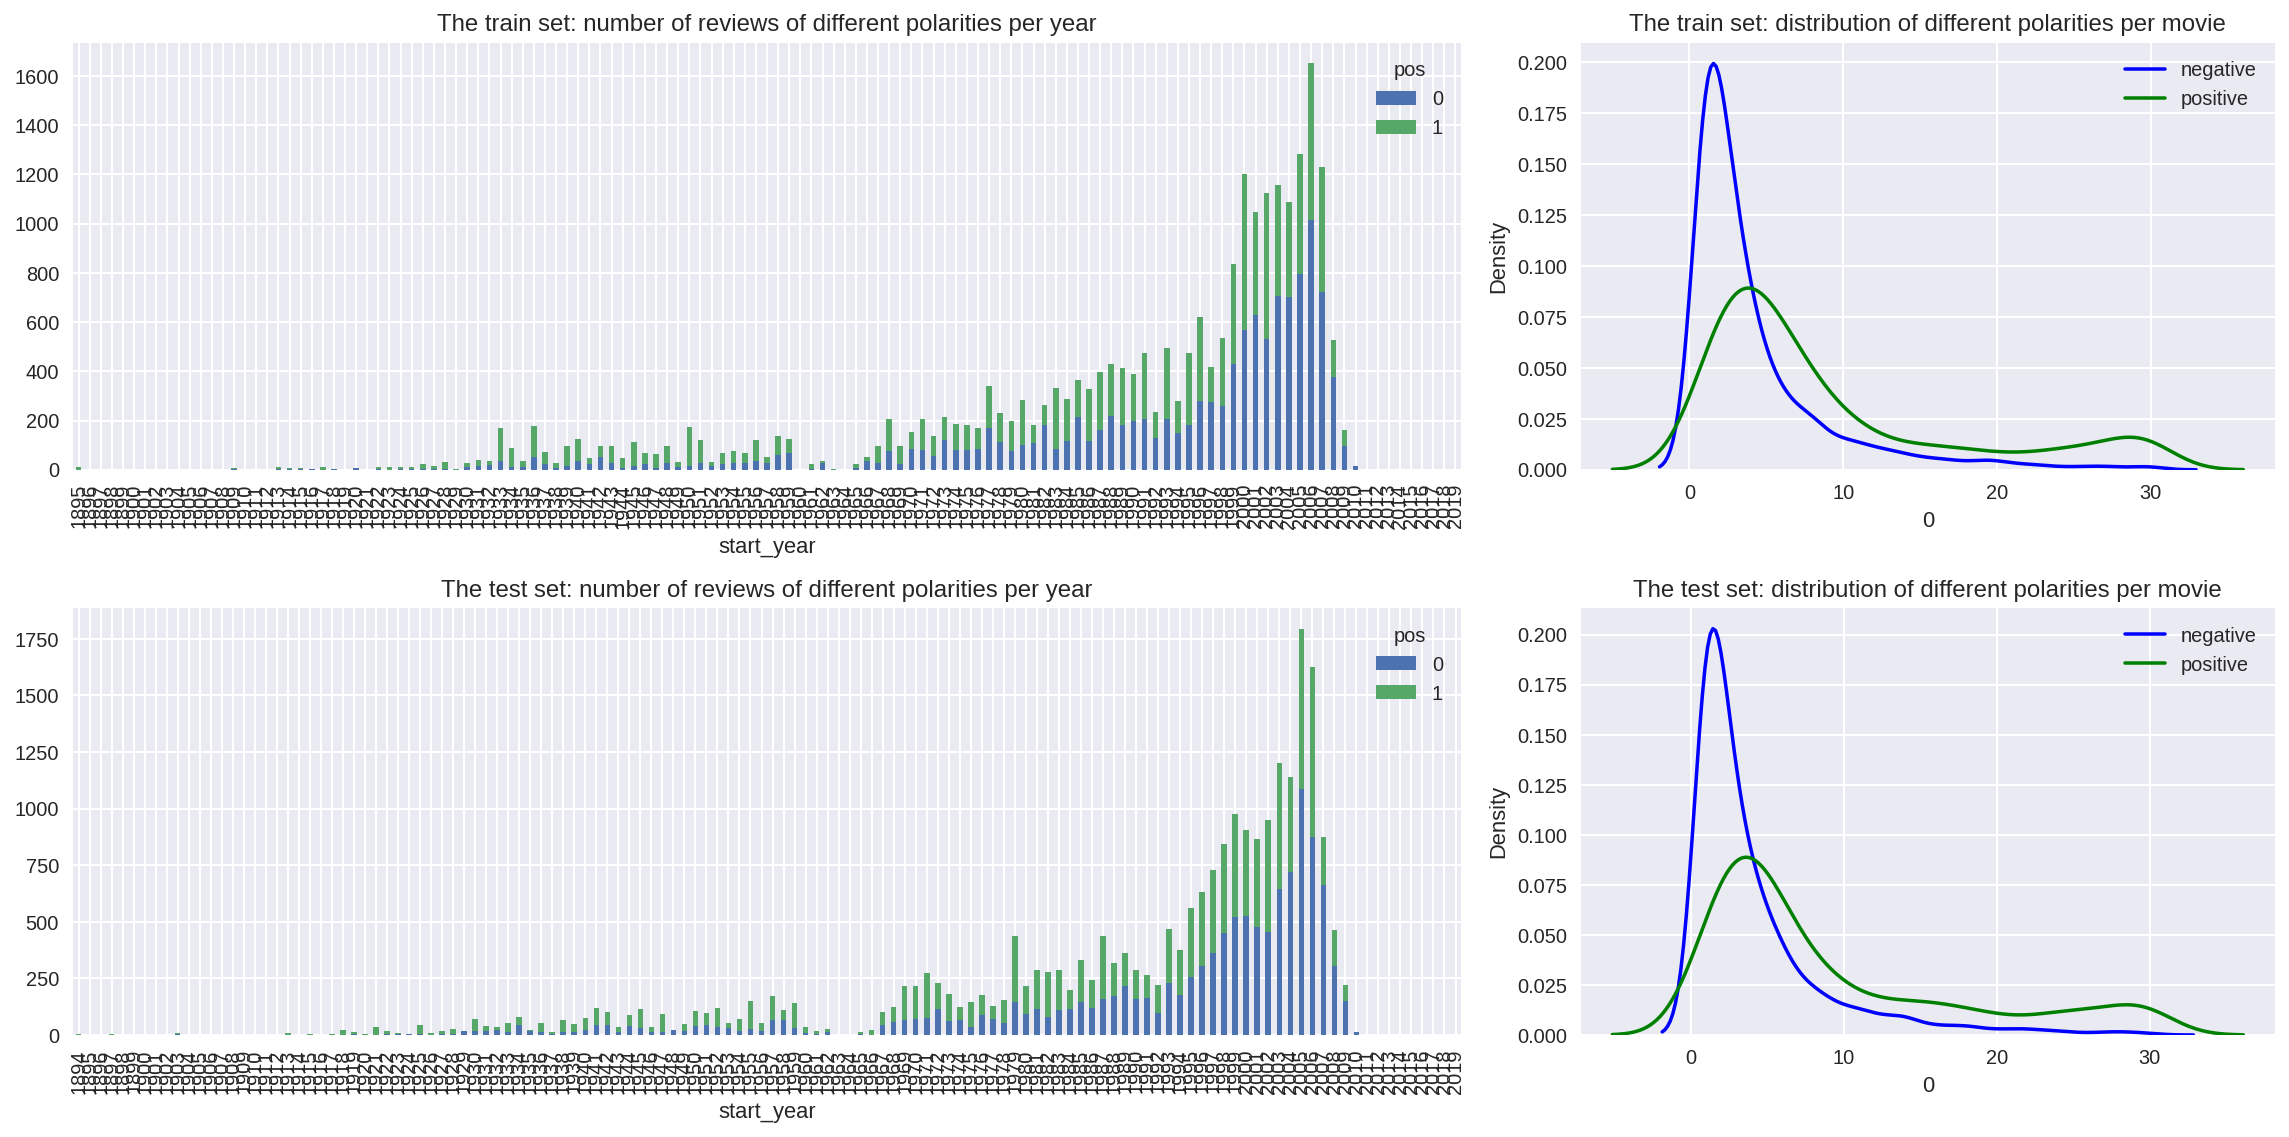

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

Distributions of pos/neg reviews, and year by year comparisons of pos/neg reviews, are generally similar between the train and test parts of the data. 

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [13]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization and lemmatization

We assume all models below accept texts in lowercase and without any digits, punctuations marks etc. The following functions will clean the texts and lemmatize them. 

In [14]:
# Remove digits, punctuations marks etc., turn to lowercase, and lemmatize: 

import re
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def clear_text(text):
    
    pattern = r"[^a-zA-Z']"
    text = re.sub(pattern, " ", text)
    text = text.split()
    text = " ".join(text)
    return text

def lemmatize(text):

    doc = nlp(text.lower())
    
    lemmas = []
    for token in doc:
        lemmas.append(token.lemma_)
        
    return ' '.join(lemmas)

df_reviews['review_norm'] = df_reviews['review'].progress_apply(
  lambda x: lemmatize(clear_text(x)))

  0%|          | 0/47331 [00:00<?, ?it/s]

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [15]:
# Split into train and test sets: 
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


In [16]:
# Defining the features:
train_features = df_reviews_train['review_norm']
test_features = df_reviews_test['review_norm'] 

## Working with models

### Model 0 - Constant

In [17]:
from sklearn.dummy import DummyClassifier

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


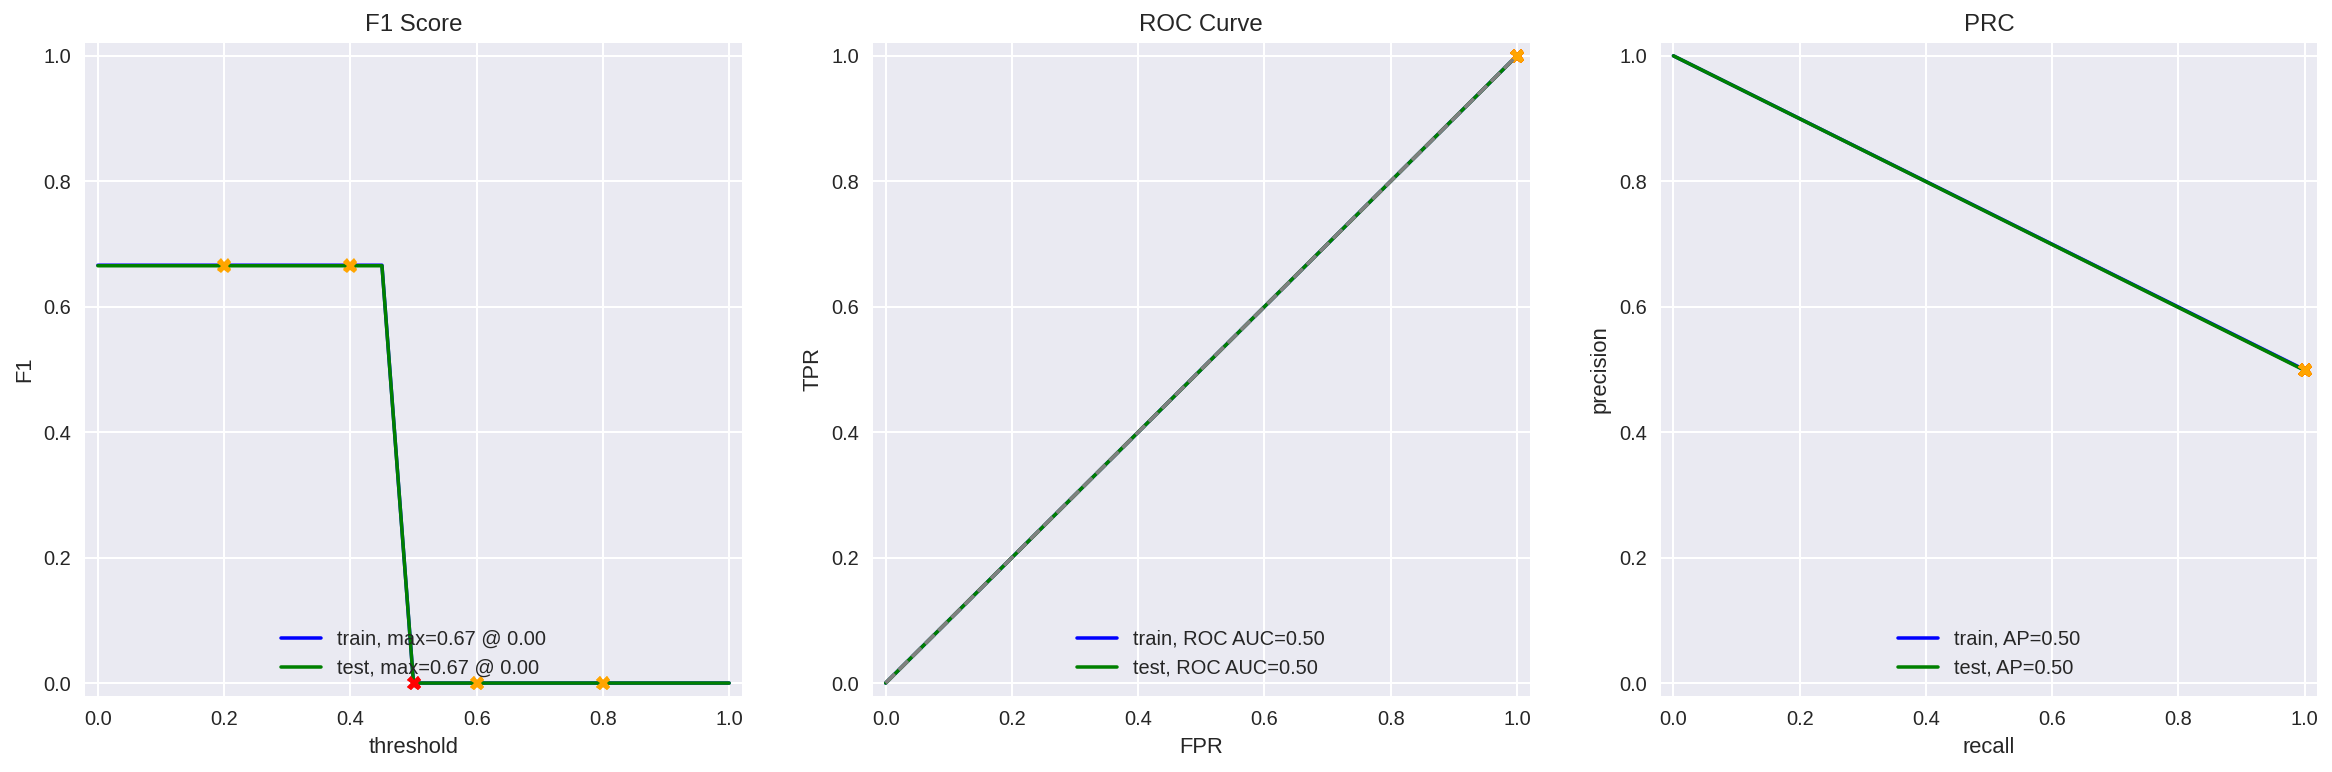

In [18]:
# A Dummy model - fit and evaluate
model = DummyClassifier()
model.fit(train_features, train_target)
evaluate_model(model, train_features, train_target, test_features, test_target)

### Model 1 - NLTK stopwords, TF-IDF and LR

Since we already used Spacy above for lemmtization, the reference here to NLTK (and below to Spacy) is about stopwords.

In [37]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords as nltk_stopwords

stop_words = set(nltk_stopwords.words('english'))
tfidf_vectorizer_1 = TfidfVectorizer(stop_words=stop_words) 

train_features_1 = tfidf_vectorizer_1.fit_transform(train_features) 

model_1 = LogisticRegression()
model_1.fit(train_features_1, train_target)

test_features_1 = tfidf_vectorizer_1.transform(test_features) 

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


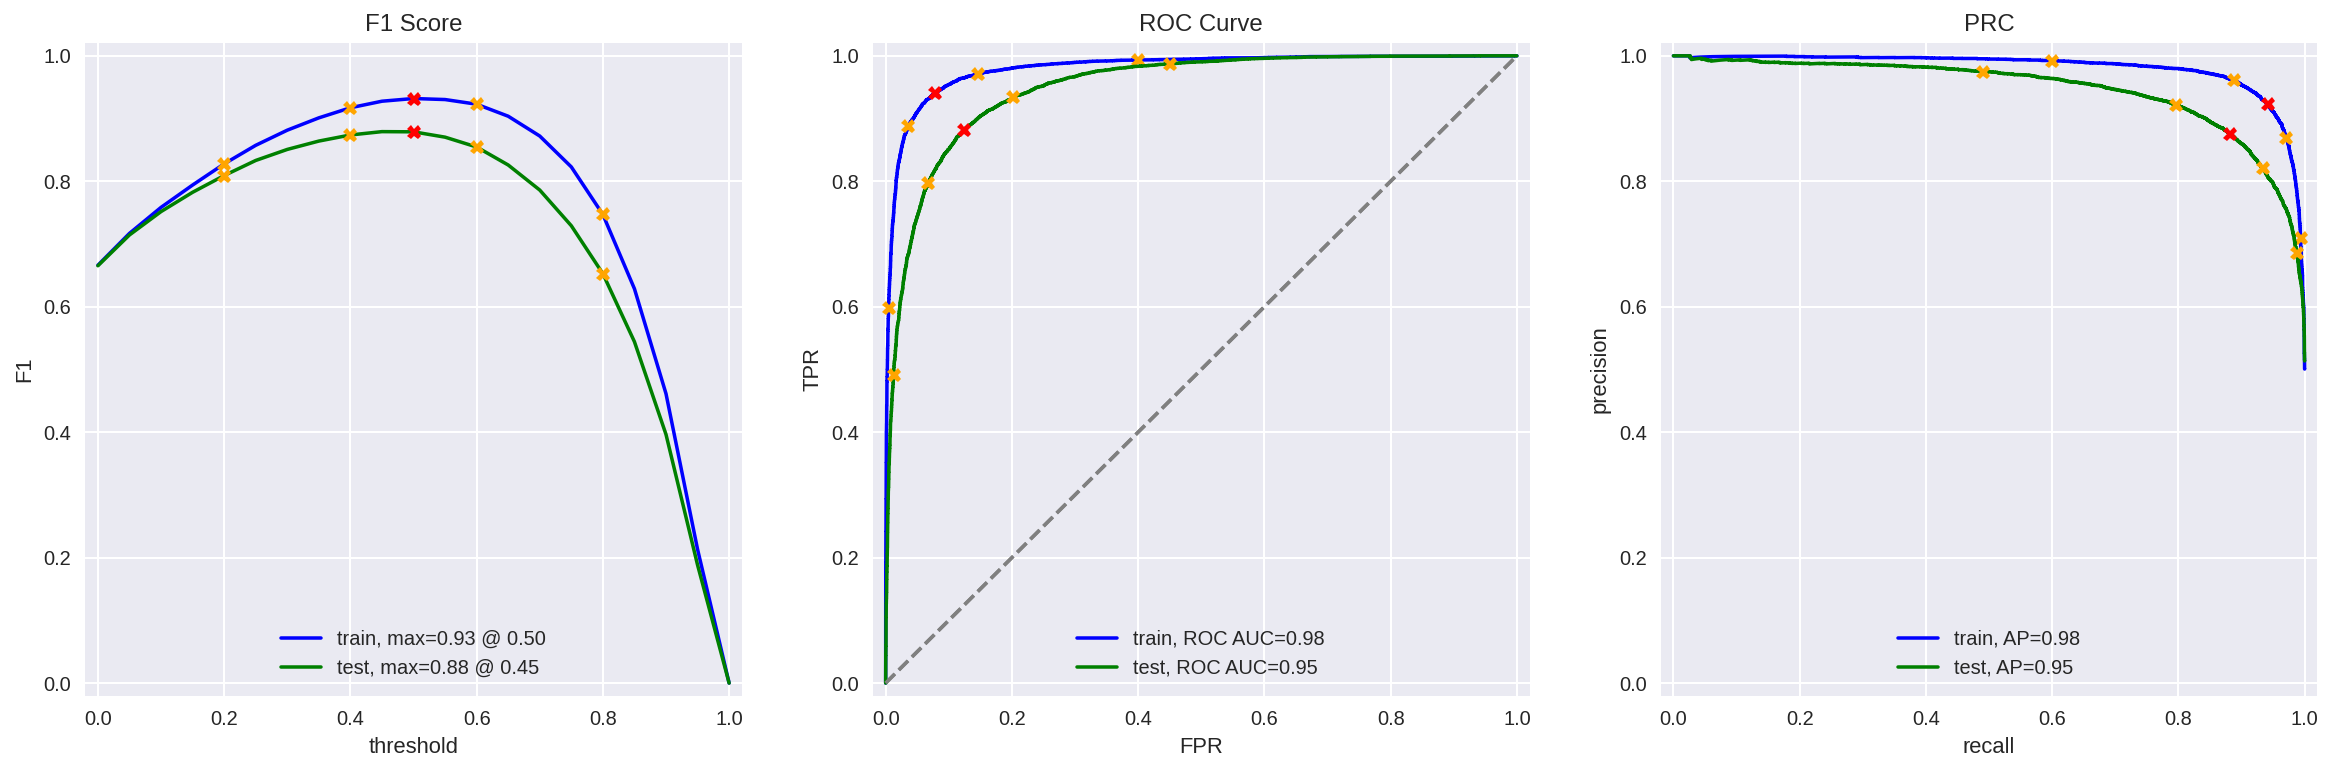

In [38]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### Model 2 - NLTK stopwords, TF-IDF and LGBMClassifier

Keeping the same tf-idf as in model 1

In [21]:
%%time
import lightgbm as lgbm
model_2 = lgbm.LGBMClassifier()
train_features_2 = train_features_1
test_features_2 = test_features_1
model_2.fit(train_features_2, train_target)

CPU times: user 1min 38s, sys: 595 ms, total: 1min 39s
Wall time: 1min 39s


LGBMClassifier()

          train  test
Accuracy   0.91  0.86
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.94


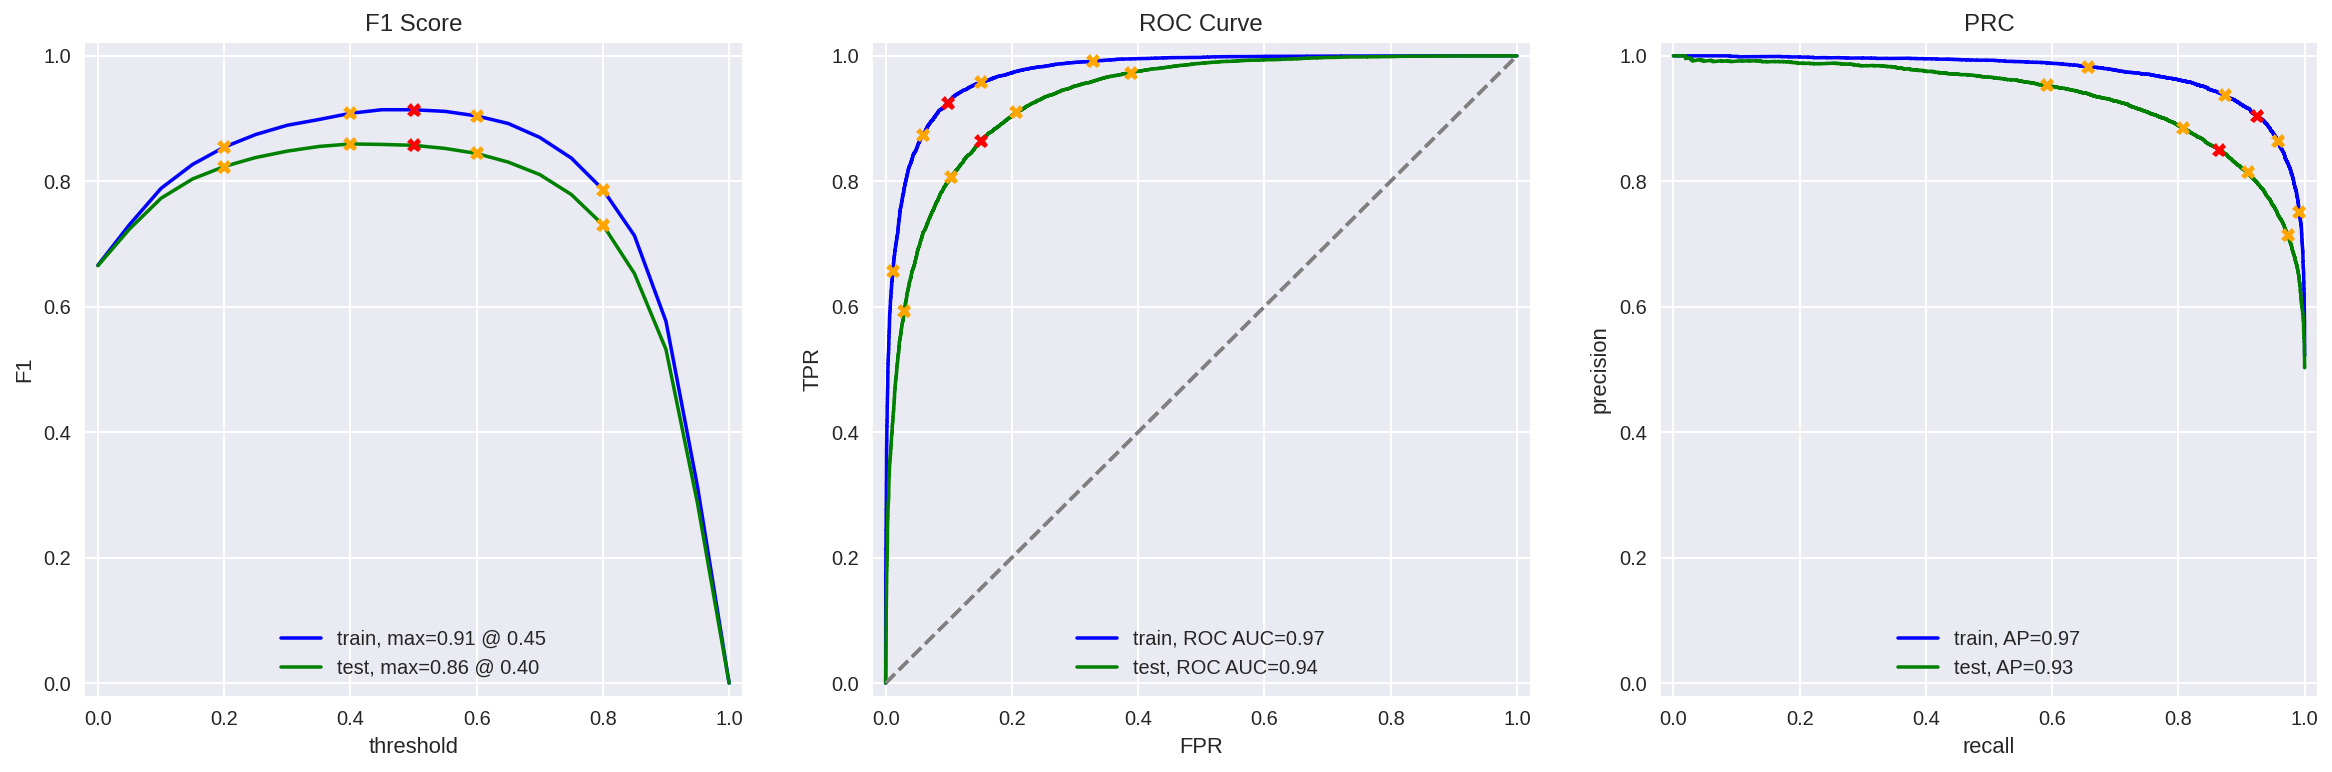

In [22]:
evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

### Model 3 - spaCy stopwords, TF-IDF and LR

Unlike the stopwords (and following tf-idf) we used based on NLTK for models 1 and 2, for models 3 and 4 we will use Spacy stopwords and create tf-idf vectorising based on it. Lemmatising based on Spacy was already done above. 

In [41]:
# Defining stopwords from Spacy (as we defined 'nlp' above), then vectorising with tf-idf, and using Logistic regression
stop_words = nlp.Defaults.stop_words
tfidf_vectorizer_3 = TfidfVectorizer(stop_words=stop_words) 

train_features_3 = tfidf_vectorizer_3.fit_transform(train_features) 

model_3 = LogisticRegression()
model_3.fit(train_features_3, train_target)

test_features_3 = tfidf_vectorizer_3.transform(test_features) 

/opt/conda/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


          train  test
Accuracy   0.93  0.87
F1         0.93  0.87
APS        0.98  0.94
ROC AUC    0.98  0.95


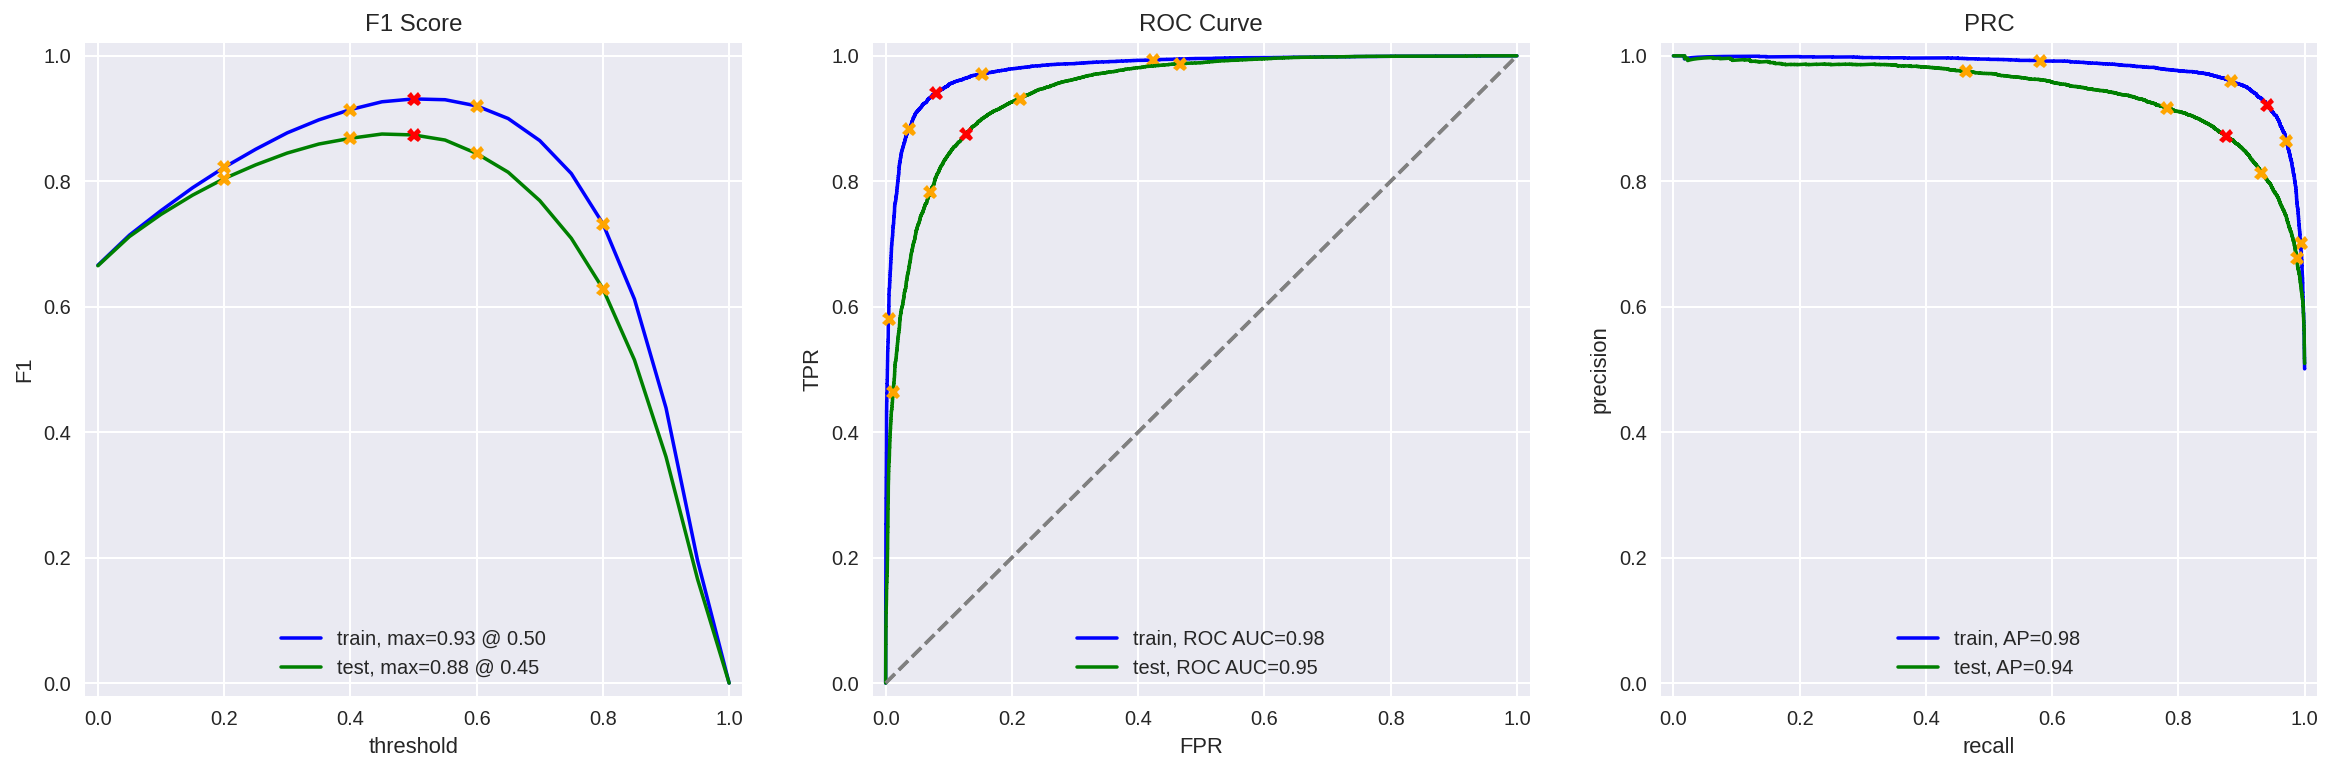

In [42]:
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target) 

### Model 4 - spaCy stopwords, TF-IDF and LGBMClassifier

Keeping the same tf-idf as model 3

In [25]:
%%time
import lightgbm as lgbm
model_4 = lgbm.LGBMClassifier()
train_features_4 = train_features_3
test_features_4 = test_features_3
model_4.fit(train_features_4, train_target)

CPU times: user 1min 29s, sys: 308 ms, total: 1min 29s
Wall time: 1min 30s


LGBMClassifier()

          train  test
Accuracy   0.93  0.87
F1         0.93  0.87
APS        0.98  0.94
ROC AUC    0.98  0.95


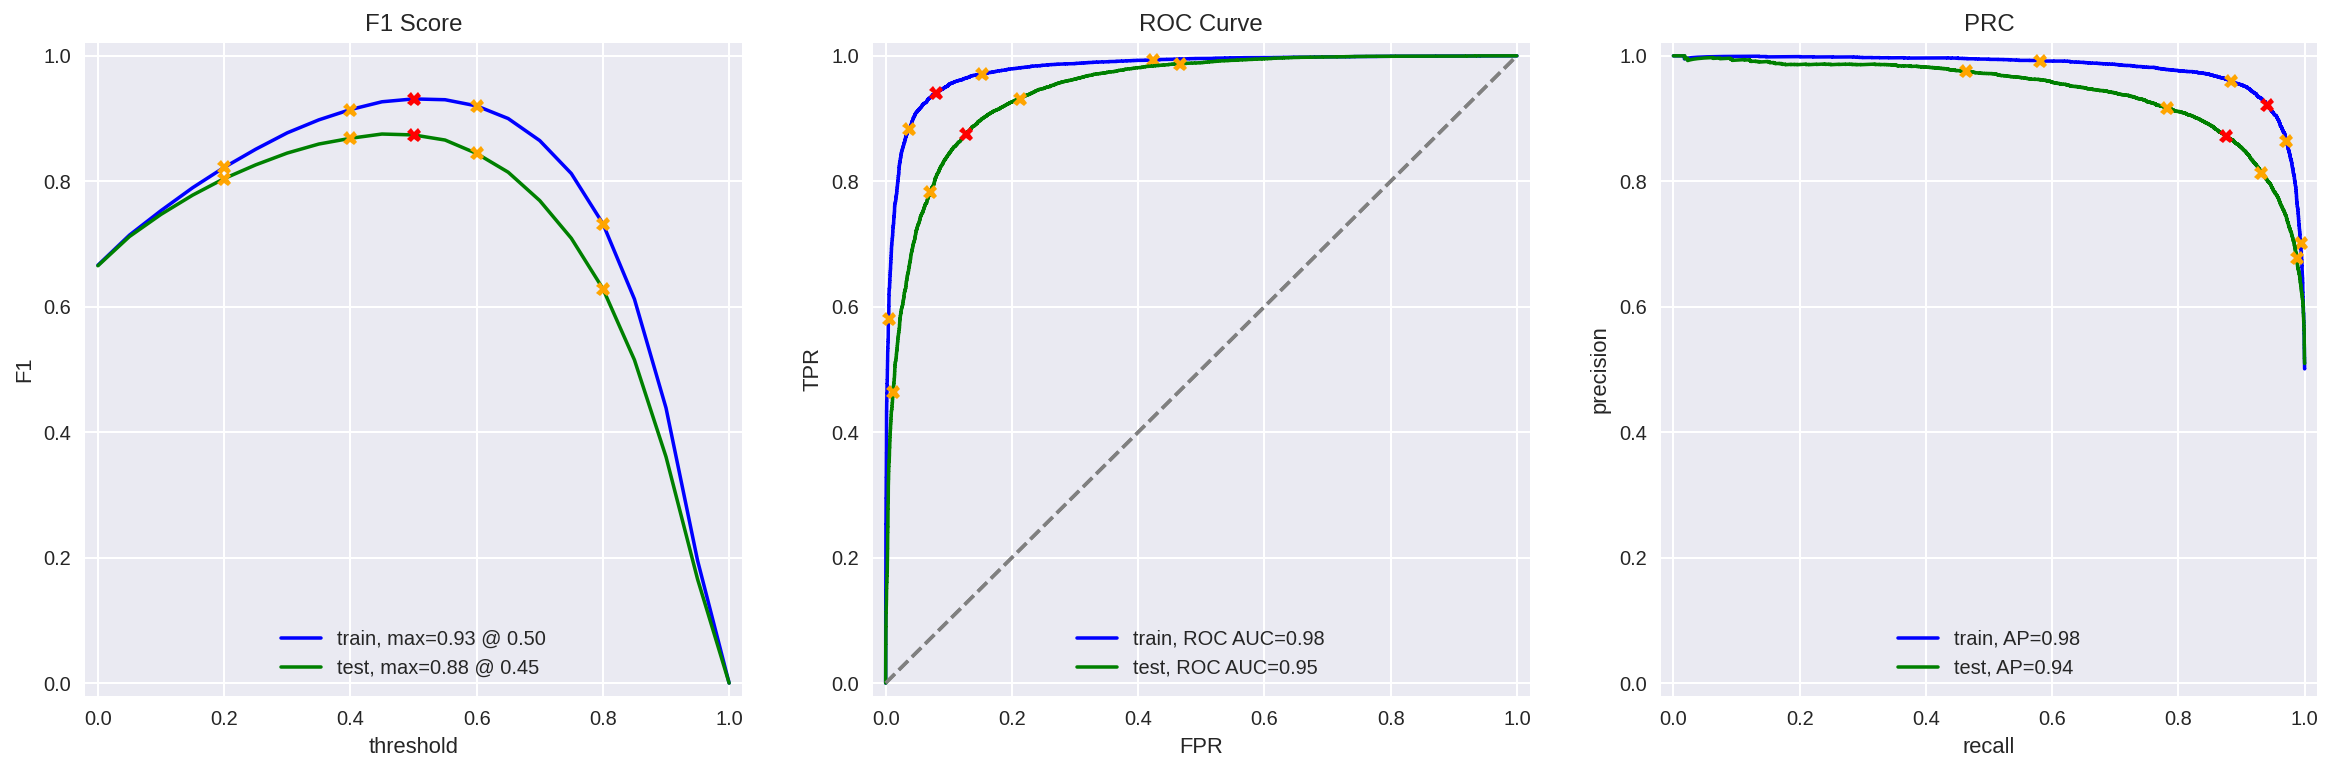

In [26]:
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target) 

All 4 models that are based on TF-IDF vectorization achieved F1 score between 0.86 - 0.88 on the test set. Best F1 score (0.88) was achieved by LR with NLTK stopwords (model 1).

###  Model 5 - BERT

In [27]:
import torch
import transformers

In [28]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [29]:
# To get embeddinds for 100 train reviews and 100 test reviews (due to limts of CPU)
max_sample_size = 100

In [30]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=10, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # text to padded ids of tokens along with their attention masks
    
    max_length = 512

    for input_text in texts.iloc[:max_sample_size]:
        ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device) 
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [31]:
# Applying BERT embeddings to the train sample 
train_features_5 = BERT_text_to_embeddings(df_reviews_train['review'])

Using the cpu device.


  0%|          | 0/8 [00:00<?, ?it/s]

/tmp/ipykernel_274/1651924293.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)


In [32]:
# Applying BERT embeddings to the test sample 
test_features_5 = BERT_text_to_embeddings(df_reviews_test['review'])

Using the cpu device.


  0%|          | 0/8 [00:00<?, ?it/s]

In [33]:
 # Defining the target samples for train and test  
train_target_5 = train_target.iloc[:max_sample_size]
test_target_5 = test_target.iloc[:max_sample_size]

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


          train  test
Accuracy    1.0  0.82
F1          1.0  0.81
APS         1.0  0.94
ROC AUC     1.0  0.93


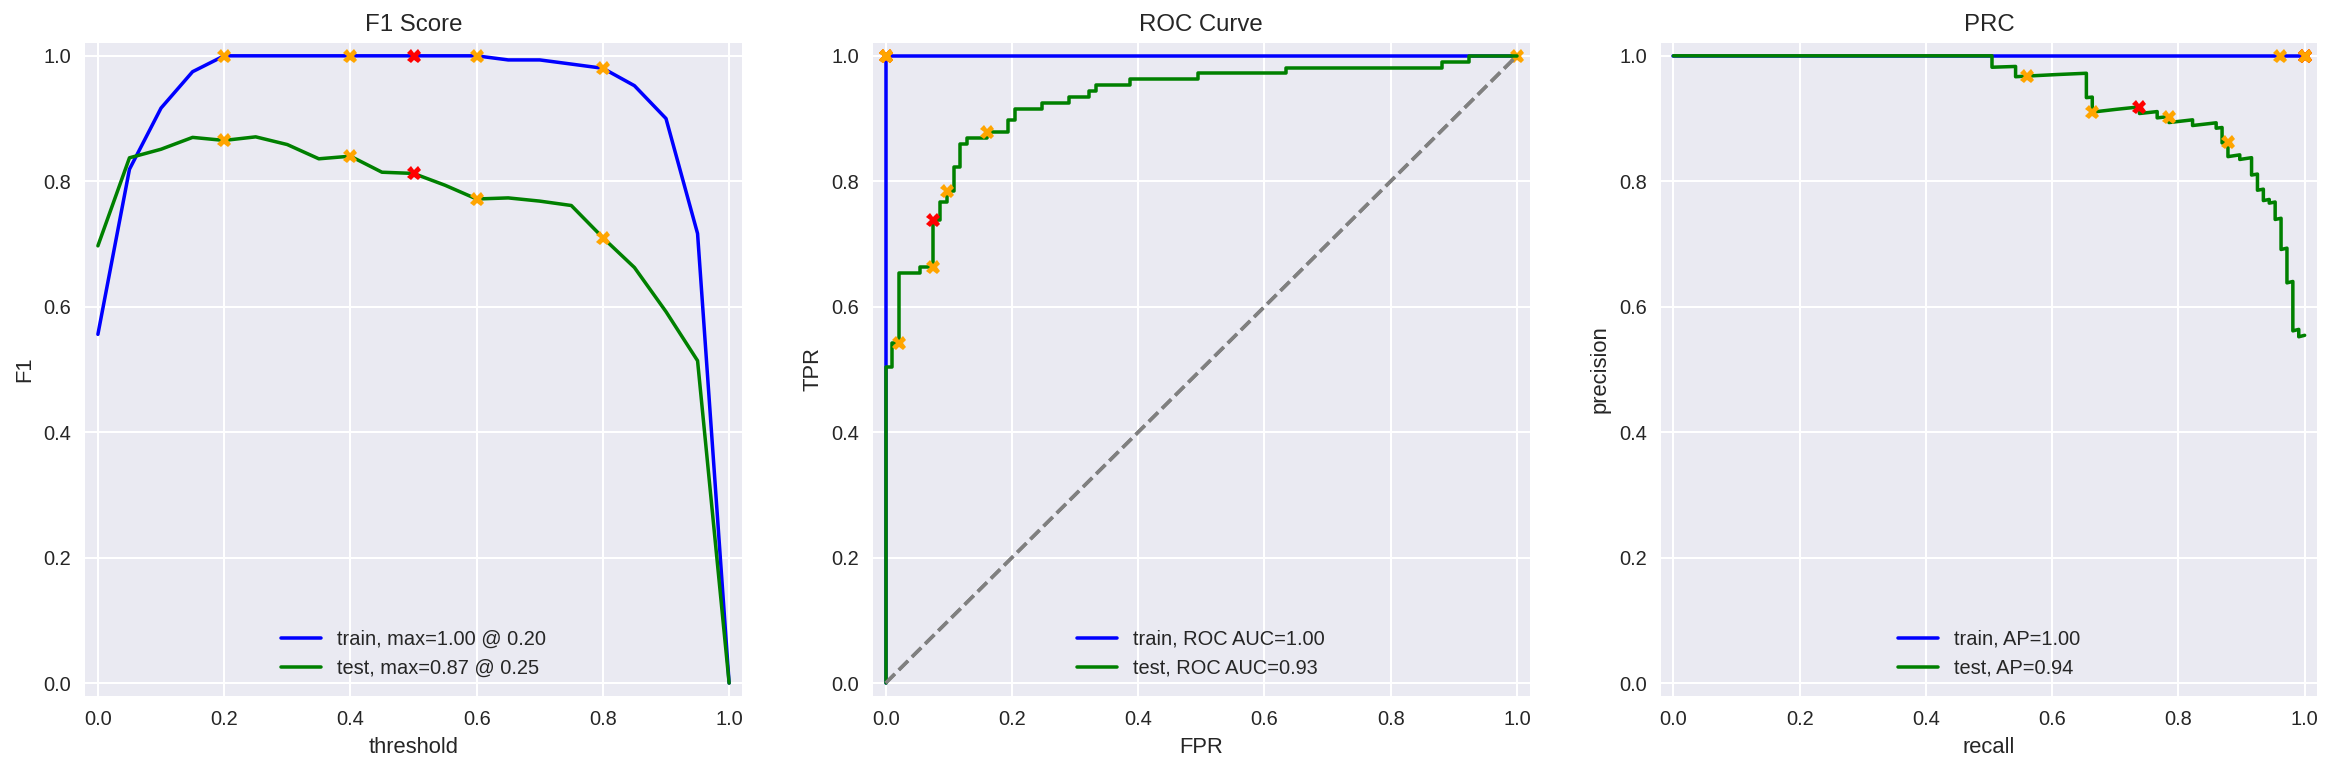

In [34]:
 # Define a LR model, training it and evaluationg it on the BERT embeddings small sample
model_5 = LogisticRegression()
model_5.fit(train_features_5, train_target_5)
evaluate_model(model_5, train_features_5, train_target_5, test_features_5, test_target_5) 

BERT-embeddings based predictions on the test sample achieved a lower F1 score (0.81) than all TF-IDF based models, but it is important to note that BERT based predictions were using only a sample of 100 reviews of the train set and 100 of the test set (vs. more than 23K (!) used by the other models of each set), and still achieved an overall F1 score above 0.8  

## My Reviews

In [35]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].progress_apply(
  lambda x: lemmatize(clear_text(x)))

my_reviews

  0%|          | 0/8 [00:00<?, ?it/s]

,review,review_norm
0,"I did not simply like it, not my kind of movie.",I do not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well I be bored and feel asleep in the middle ...
2,I was really fascinated with the movie,I be really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actor look really old and disinterest...
4,I didn't expect the reboot to be so good! Writ...,I do not expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie have its upside and downside but I f...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launch on netflix be a brave move I really app...


### Model 1

In [39]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(tfidf_vectorizer_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.20:  I do not simply like it not my kind of movie
0.12:  well I be bored and feel asleep in the middle of the movie
0.49:  I be really fascinated with the movie
0.10:  even the actor look really old and disintereste and they get pay to be in the movie what a soulless 
0.27:  I do not expect the reboot to be so good writer really care about the source material
0.50:  the movie have its upside and downside but I feel like overall it be a decent flick I could see myse
0.03:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wil
0.92:  launch on netflix be a brave move I really appreciate be able to binge on episode after episode of t


Out of the 8 reviews, we can see that only 5 were clearly classified correctly (note this is the model thhat got the highest F1 score - 0.88 - on the 23K test reviews): 2 positive reviews recieved ambigous answer (0.49, 0.50), and one positive review was wrongly classified as negative (0.27). It might be due to the limited vocabulary and/or unique expressions in each specific review, and in some cases to the more complex message of the text (like in the review that got here 0.50, but is eventually positive).  

### Model 2

In [40]:
texts = my_reviews['review_norm']

tfidf_vectorizer_2 = tfidf_vectorizer_1
my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.53:  I do not simply like it not my kind of movie
0.40:  well I be bored and feel asleep in the middle of the movie
0.60:  I be really fascinated with the movie
0.38:  even the actor look really old and disintereste and they get pay to be in the movie what a soulless 
0.73:  I do not expect the reboot to be so good writer really care about the source material
0.61:  the movie have its upside and downside but I feel like overall it be a decent flick I could see myse
0.26:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wil
0.80:  launch on netflix be a brave move I really appreciate be able to binge on episode after episode of t


Interesting to see, LGBMClassifier (model 2) provided different results than LR (model 1): generally speaking almost all results are more tended to positive classification (higher pred_prob) than LR. It performed better than model 1 on the 2 positive texts that model 1 classified ambigously (here getting 0.60 and 0.61), and identified correctly the positive review that model 1 missed (here 0.73). But on the other hand it was ambigous/pos (0.53) about the first negative review, that was clearly classified correctly by model 1 (0.20 there). This shows that different algorythms on the same TF-IDF of the same texts, and when the models are trained on the same texts - can provide different classifications. 

### Model 3

In [43]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.17:  I do not simply like it not my kind of movie
0.07:  well I be bored and feel asleep in the middle of the movie
0.51:  I be really fascinated with the movie
0.14:  even the actor look really old and disintereste and they get pay to be in the movie what a soulless 
0.23:  I do not expect the reboot to be so good writer really care about the source material
0.45:  the movie have its upside and downside but I feel like overall it be a decent flick I could see myse
0.03:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wil
0.91:  launch on netflix be a brave move I really appreciate be able to binge on episode after episode of t


Comparing to model 1 (both LR but here with Spacy stopwords rather than NLTK stopwords) - we see similar, but not identical, results.  

### Model 4

In [44]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.52:  I do not simply like it not my kind of movie
0.23:  well I be bored and feel asleep in the middle of the movie
0.58:  I be really fascinated with the movie
0.45:  even the actor look really old and disintereste and they get pay to be in the movie what a soulless 
0.70:  I do not expect the reboot to be so good writer really care about the source material
0.51:  the movie have its upside and downside but I feel like overall it be a decent flick I could see myse
0.25:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wil
0.78:  launch on netflix be a brave move I really appreciate be able to binge on episode after episode of t


As with the two LR models, the two LGBMClassifier models (model 2 and model 4) show similar, but not identical, results. Overall, out of 4 negative reviews - this model clearly identified only 2 (0.23, 0.25). Probably for the same reasons that were metioned above - due to the limited vocabulary and/or unique expressions in each specific review, and in some cases to the more complex message of the text. 

### Model 5

In [46]:
texts = my_reviews['review_norm']

my_reviews_features_5 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_5.predict_proba(my_reviews_features_5)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.05:  I do not simply like it not my kind of movie
0.01:  well I be bored and feel asleep in the middle of the movie
0.26:  I be really fascinated with the movie
0.01:  even the actor look really old and disintereste and they get pay to be in the movie what a soulless 
0.24:  I do not expect the reboot to be so good writer really care about the source material
0.98:  the movie have its upside and downside but I feel like overall it be a decent flick I could see myse
0.01:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wil
0.97:  launch on netflix be a brave move I really appreciate be able to binge on episode after episode of t


The BERT model shows a different picture: no ambiguity, all pred_prob show clear-cut classification, yet with high tendency to classify neg. Two positive reviews were wrongly (and strongly) classified negative (0.26, 0.24). The different method is clear in the different results. The mistakes probably stem from the very very limited data BERT was trained on (due to limited CPU).  

## Conclusions

A few models were trained and evaluated, the best F1 score (on the test set) was 0.88 (passing the metric desired threshold), and it was achieved by LogisticRegression model, after using TF-IDF for vectorising the review texts (lemmatized with Spacy, stopwords with NLTK).

All 4 models that were based on TF-IDF vectorization achieved F1 score between 0.86 - 0.88 (all passing the metric desired threshold). 

Due to CPU limits, and just for experiencing, BERT was used for a very small sample and with a very small batch size (and yet achieved f1 score of 0.81). 

When classifiying specific short example reviews (not from the IMDB dataset) - The best (on the dataset) model clearly classified correctly only 5 out of 8 reviews. Probably due to the limited vocabulary and/or unique expressions in each specific review, and in some cases to the more complex message of the text. 
On the 8 short sentences there were differences in classification between LR and LGBMClassifier models (and smaller differences between models with same algorythm but different library for stopwords). The BERT model shows a different picture: no ambiguity, all pred_prob show clear-cut classification, yet with high tendency to classify neg. The different method is clear in the different results. The BERT mistakes here probably stem from the very very limited data BERT was trained on (due to limited CPU).    